In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns

In [31]:
db_path = '/auto/users/hellerc/code/nems_db/'

In [32]:
batch = 309
cutoff = 0.5  # octaves from target freq to be considered ON BF

In [33]:
# load model results data
dMI = pd.read_csv(db_path+'nems_lbhb/pupil_behavior_scripts/d_{}_pup_fil_sdexp_afl.csv'.format(batch), index_col=0)

try:
    dMI['r'] = [np.float(r.strip('[]')) for r in dMI['r'].values]
    dMI['r_se'] = [np.float(r.strip('[]')) for r in dMI['r_se'].values]
except:
    pass

# remove AMT cells
dMI = dMI[~dMI.cellid.str.contains('AMT')]

# get task model params / MI
cols = ['cellid', 'state_chan_alt', 'MI', 'g_amplitude', 'g_base', 'g_kappa', 'g_offset',
                                          'd_amplitude', 'd_base', 'd_kappa', 'd_offset', 'r', 'r_se']
file_merge = dMI[(dMI['state_sig']=='st.pup.afl') & (dMI['state_chan_alt'].str.contains('ACTIVE'))][cols].merge(\
                dMI[(dMI['state_sig']=='st.pup.afl0') & (dMI['state_chan_alt'].str.contains('ACTIVE'))][cols], \
                on=['cellid', 'state_chan_alt'])

def fn_task(a, b, k, o):
    high = b + a * np.exp(-np.exp(-np.exp(k) * (1 - o)))
    lo = b + a * np.exp(-np.exp(-np.exp(k) * (0 - o)))
    return (high - lo) #/ (high + lo)

def fn_pupil(a, b, k, o):
    high = b + a * np.exp(-np.exp(-np.exp(k) * (.5 - o)))
    lo = b + a * np.exp(-np.exp(-np.exp(k) * (-.5 - o)))
    return (high - lo) #/ (high + lo)

def fn_pxf(a, b, k, o):
    high = b + a * np.exp(-np.exp(-np.exp(k) * (1 - o)))
    lo = b + a * np.exp(-np.exp(-np.exp(k) * (0 - o)))
    return (high - lo)  


file_merge['gain_task'] = [fn_task(a, b, k, o) for (a, b, k, o) in 
                        zip(file_merge['g_amplitude_x'], file_merge['g_base_x'], file_merge['g_kappa_x'], file_merge['g_offset_x'])]
file_merge['MI_task'] = file_merge['MI_x'] - file_merge['MI_y']
file_merge['dc_task'] = [fn_task(a, b, k, o) for (a, b, k, o) in 
                                   zip(file_merge['d_amplitude_x'], file_merge['d_base_x'], file_merge['d_kappa_x'], file_merge['d_offset_x'])]

file_merge['sig_task'] = [True if ((file_merge.iloc[i]['r_x'] - file_merge.iloc[i]['r_y']) > 
                                       (file_merge.iloc[i]['r_se_x'] + file_merge.iloc[i]['r_se_y'])) else False for i in range(file_merge.shape[0])]


# strip extraneous columns
file_merge = file_merge.drop(columns=[c for c in file_merge.columns if ('_x' in c) | ('_y' in c)])

# get pupil model params / MI
pupil_merge = dMI[(dMI['state_sig']=='st.pup.afl') & (dMI['state_chan_alt']=='pupil')][cols].merge(\
                dMI[(dMI['state_sig']=='st.pup0.afl') & (dMI['state_chan_alt']=='pupil')][cols], \
                on=['cellid', 'state_chan_alt'])

pupil_merge['gain_pupil'] = [fn_pupil(a, b, k, o) for (a, b, k, o) in 
                                   zip(pupil_merge['g_amplitude_x'], pupil_merge['g_base_x'], pupil_merge['g_kappa_x'], pupil_merge['g_offset_x'])]
pupil_merge['MI_pupil'] = pupil_merge['MI_x'] - pupil_merge['MI_y']
pupil_merge['dc_pupil'] = [fn_pupil(a, b, k, o) for (a, b, k, o) in 
                                   zip(pupil_merge['d_amplitude_x'], pupil_merge['d_base_x'], pupil_merge['d_kappa_x'], pupil_merge['d_offset_x'])]

pupil_merge['sig_pupil'] = [True if ((pupil_merge.iloc[i]['r_x'] - pupil_merge.iloc[i]['r_y']) > 
                                        (pupil_merge.iloc[i]['r_se_x'] + pupil_merge.iloc[i]['r_se_y'])) else False for i in range(pupil_merge.shape[0])]

# strip extraneous columns
pupil_merge = pupil_merge.drop(columns=[c for c in pupil_merge.columns if ('_x' in c) | ('_y' in c)])
pupil_merge = pupil_merge.drop(columns=['state_chan_alt'])

# load BF / SNR data
dBF = pd.read_csv(db_path+'nems_lbhb/pupil_behavior_scripts/d_{}_tuning.csv'.format(batch), index_col=0)
dBF.index.name = 'cellid'

# load tar frequencies
dTF = pd.read_csv(db_path+'nems_lbhb/pupil_behavior_scripts/d_{}_tar_freqs.csv'.format(batch), index_col=0)

# merge results into single df
df = file_merge.merge(dTF, on=['cellid', 'state_chan_alt'])
df = df.merge(pupil_merge, on=['cellid'])
df.index = df.cellid
df = df.drop(columns=['cellid'])

df = df.merge(dBF, left_index=True, right_index=True)

# add column classifying octave sep. from target
df['oct_diff'] = abs(np.log2(df['tar_freq'] / df['BF']))

# add column for on cells / off cells
df['ON_BF'] = [True if df.iloc[i]['oct_diff']<=cutoff else False for i in range(df.shape[0])]
df['OFF_BF'] = [True if df.iloc[i]['oct_diff']>cutoff else False for i in range(df.shape[0])]

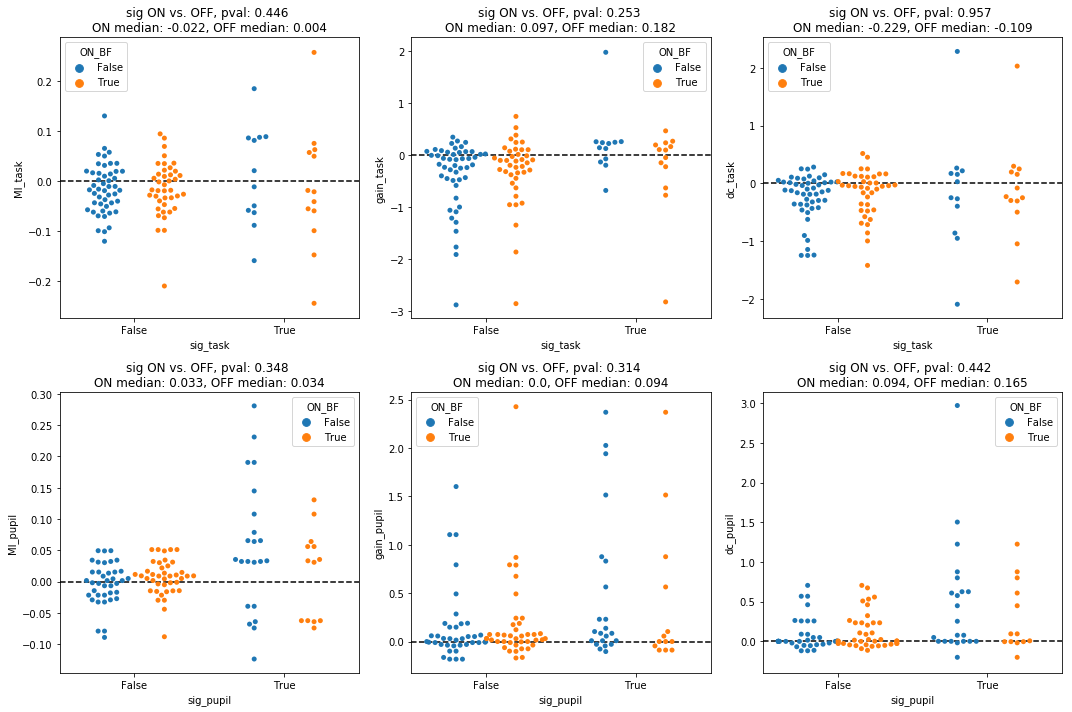

In [29]:
fix_ylims = False
data = df.copy()

f, ax = plt.subplots(2, 3, figsize=(15, 10))

# BEHAVIOR results
# MI
sns.swarmplot(x='sig_task', y='MI_task', hue='ON_BF', data=data, dodge=True, ax=ax[0, 0])
ax[0, 0].axhline(0, linestyle='--', color='k')
pval = np.round(ss.ranksums(df[df['sig_task'] & df['ON_BF']]['MI_task'], df[df['sig_task'] & df['OFF_BF']]['MI_task']).pvalue, 3)
on_median = np.round(df[df['sig_task'] & df['ON_BF']]['MI_task'].median(), 3)
off_median = np.round(df[df['sig_task'] & df['OFF_BF']]['MI_task'].median(), 3)
ax[0, 0].set_title('sig ON vs. OFF, pval: {0} \n'
                    'ON median: {1}, OFF median: {2}'.format(pval, on_median, off_median))

# Gain
sns.swarmplot(x='sig_task', y='gain_task', hue='ON_BF', data=data, dodge=True, ax=ax[0, 1])
ax[0, 1].axhline(0, linestyle='--', color='k')
pval = np.round(ss.ranksums(df[df['sig_task'] & df['ON_BF']]['gain_task'], df[df['sig_task'] & df['OFF_BF']]['gain_task']).pvalue, 3)
on_median = np.round(df[df['sig_task'] & df['ON_BF']]['gain_task'].median(), 3)
off_median = np.round(df[df['sig_task'] & df['OFF_BF']]['gain_task'].median(), 3)
ax[0, 1].set_title('sig ON vs. OFF, pval: {0} \n'
                    'ON median: {1}, OFF median: {2}'.format(pval, on_median, off_median))

# DC
sns.swarmplot(x='sig_task', y='dc_task', hue='ON_BF', data=data, dodge=True, ax=ax[0, 2])
ax[0, 2].axhline(0, linestyle='--', color='k')
pval = np.round(ss.ranksums(df[df['sig_task'] & df['ON_BF']]['dc_task'], df[df['sig_task'] & df['OFF_BF']]['dc_task']).pvalue, 3)
on_median = np.round(df[df['sig_task'] & df['ON_BF']]['dc_task'].median(), 3)
off_median = np.round(df[df['sig_task'] & df['OFF_BF']]['dc_task'].median(), 3)
ax[0, 2].set_title('sig ON vs. OFF, pval: {0} \n'
                    'ON median: {1}, OFF median: {2}'.format(pval, on_median, off_median))

# PUPIL results
# MI
sns.swarmplot(x='sig_pupil', y='MI_pupil', hue='ON_BF', data=data, dodge=True, ax=ax[1, 0])
ax[1, 0].axhline(0, linestyle='--', color='k')
pval = np.round(ss.ranksums(df[df['sig_pupil'] & df['ON_BF']]['MI_pupil'], df[df['sig_pupil'] & df['OFF_BF']]['MI_pupil']).pvalue, 3)
on_median = np.round(df[df['sig_pupil'] & df['ON_BF']]['MI_pupil'].median(), 3)
off_median = np.round(df[df['sig_pupil'] & df['OFF_BF']]['MI_pupil'].median(), 3)
ax[1, 0].set_title('sig ON vs. OFF, pval: {0} \n'
                    'ON median: {1}, OFF median: {2}'.format(pval, on_median, off_median))

# Gain
sns.swarmplot(x='sig_pupil', y='gain_pupil', hue='ON_BF', data=data, dodge=True, ax=ax[1, 1])
ax[1, 1].axhline(0, linestyle='--', color='k')
pval = np.round(ss.ranksums(df[df['sig_pupil'] & df['ON_BF']]['gain_pupil'], df[df['sig_pupil'] & df['OFF_BF']]['gain_pupil']).pvalue, 3)
on_median = np.round(df[df['sig_pupil'] & df['ON_BF']]['gain_pupil'].median(), 3)
off_median = np.round(df[df['sig_pupil'] & df['OFF_BF']]['gain_pupil'].median(), 3)
ax[1, 1].set_title('sig ON vs. OFF, pval: {0} \n'
                    'ON median: {1}, OFF median: {2}'.format(pval, on_median, off_median))

# DC
sns.swarmplot(x='sig_pupil', y='dc_pupil', hue='ON_BF', data=data, dodge=True, ax=ax[1, 2])
ax[1, 2].axhline(0, linestyle='--', color='k')
pval = np.round(ss.ranksums(df[df['sig_pupil'] & df['ON_BF']]['dc_pupil'], df[df['sig_pupil'] & df['OFF_BF']]['dc_pupil']).pvalue, 3)
on_median = np.round(df[df['sig_pupil'] & df['ON_BF']]['dc_pupil'].median(), 3)
off_median = np.round(df[df['sig_pupil'] & df['OFF_BF']]['dc_pupil'].median(), 3)
ax[1, 2].set_title('sig ON vs. OFF, pval: {0} \n'
                    'ON median: {1}, OFF median: {2}'.format(pval, on_median, off_median))

if fix_ylims:
    for a in [ax[0, 1], ax[0, 2], ax[1, 1], ax[1, 2]]:
        a.set_ylim((-2, 2))
        
f.tight_layout()

In [19]:
on_cells = df[df['ON_BF']].index.unique()
off_cells = df[df['OFF_BF']].index.unique()
matched = np.unique([c for c in df.index.unique() if (c in on_cells.values) & (c in off_cells.values)])
print('{0} cellids found for both condtions'.format(len(matched)))

19 cellids found for both condtions


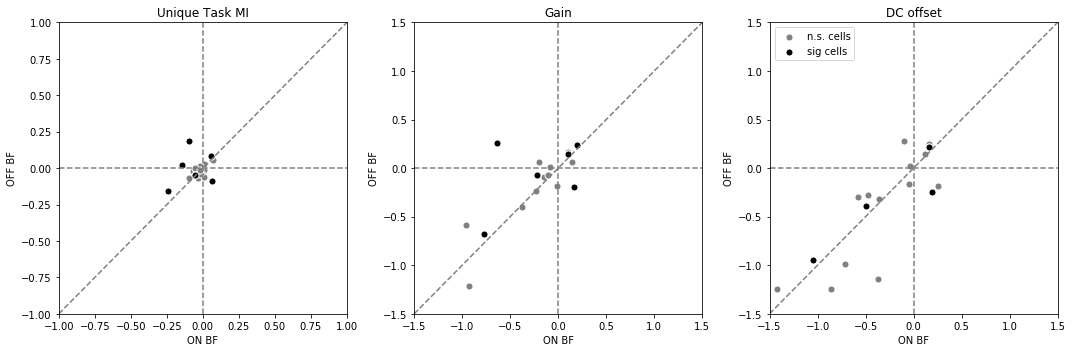

In [20]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))

taskON = df[df.index.isin(matched) & (df.ON_BF)].groupby(by='cellid').mean()
taskOFF = df[df.index.isin(matched) & (df.OFF_BF)].groupby(by='cellid').mean()

ax[0].set_title('Unique Task MI')
ax[0].scatter(taskON['MI_task'], taskOFF['MI_task'], color='grey', edgecolor='white', s=50)
ax[0].scatter(taskON[taskON.sig_task]['MI_task'], 
                taskOFF[taskOFF.sig_task]['MI_task'], color='k', edgecolor='white', s=50)
ax[0].plot([-1, 1], [-1, 1], 'grey', linestyle='--')
ax[0].axhline(0, linestyle='--', color='grey')
ax[0].axvline(0, linestyle='--', color='grey')
ax[0].set_xlim((-1, 1))
ax[0].set_ylim((-1, 1))
ax[0].set_xlabel('ON BF')
ax[0].set_ylabel('OFF BF')

axlim = 1.5
ax[1].set_title('Gain')
ax[1].scatter(taskON['gain_task'], taskOFF['gain_task'], color='grey', edgecolor='white', s=50)
ax[1].scatter(taskON[taskON.sig_task]['gain_task'], 
                taskOFF[taskOFF.sig_task]['gain_task'], color='k', edgecolor='white', s=50)
ax[1].plot([-axlim, axlim], [-axlim, axlim], 'grey', linestyle='--')
ax[1].axhline(0, linestyle='--', color='grey')
ax[1].axvline(0, linestyle='--', color='grey')
ax[1].set_xlim((-axlim, axlim))
ax[1].set_ylim((-axlim, axlim))
ax[1].set_xlabel('ON BF')
ax[1].set_ylabel('OFF BF')

ax[2].set_title('DC offset')
ax[2].scatter(taskON['dc_task'], taskOFF['dc_task'], color='grey', edgecolor='white', s=50, label='n.s. cells')
ax[2].scatter(taskON[taskON.sig_task]['dc_task'], 
                taskOFF[taskOFF.sig_task]['dc_task'], color='k', edgecolor='white', s=50, label='sig cells')
ax[2].plot([-axlim, axlim], [-axlim, axlim], 'grey', linestyle='--')
ax[2].axhline(0, linestyle='--', color='grey')
ax[2].axvline(0, linestyle='--', color='grey')
ax[2].legend()
ax[2].set_xlim((-axlim, axlim))
ax[2].set_ylim((-axlim, axlim))
ax[2].set_xlabel('ON BF')
ax[2].set_ylabel('OFF BF')

f.tight_layout()